We will use **meshpy** packaage: https://anaconda.org/conda-forge/meshpy

In [1]:
import scipy as sp
from scipy import io
import meshpy.triangle as triangle
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pt
import math
import scipy.sparse
import scipy.sparse.linalg

The following function implements **writing to a file (in order to update the mesh)**. The inputs are: mesh (generated by meshpy), facets (pairs of points that define boundary), and f which is the file name to which the function writes

In [2]:
def write_dat(mesh,facets,f):
    if type(f) is str:
            f = open(f, 'w')
    
    # coordinates of all nodes
    mesh_points = np.array(mesh.points)
    # unique triangles defined as the combination of 3 nodes 
    mesh_tris = np.array(mesh.elements)
    
    p_count = mesh_points.shape[0]
    t_count = mesh_tris.shape[0]
    f_count = len(facets)
    
    # write the nodes
    f.write(str(p_count))    
    f.write('\n') 
    for i in range(p_count):
        f.write(str(mesh_points[i][0]))
        f.write(' ')
        f.write(str(mesh_points[i][1]))
        f.write('\n') 
    
    # write the triangles    
    f.write(str(t_count))
    f.write('\n')
    for i in range(t_count):
        f.write(str(mesh_tris[i][0]))
        f.write(' ')
        f.write(str(mesh_tris[i][1]))
        f.write(' ')
        f.write(str(mesh_tris[i][2]))
        f.write('\n')
    
    # write the facets    
    f.write(str(f_count))
    f.write('\n')
    for i in range(f_count):
        f.write(str(facets[i][0]))
        f.write(' ')
        f.write(str(facets[i][1]))
        f.write('\n')  

The function below **reads from file f **, it returns 3 arrays  mp (coordinates of all nodes of the mesh), mt (triangles, defined as the combination of 3 nodes), mf (pairs of points which are on the boundary; the so-called facets)

In [3]:
def read_dat(f):
    if type(f) is str:
            f = open(f, 'r')
    points = []
    
    # read the nodes
    n_points = int(f.readline())
    for i in range(n_points):
        pp = f.readline().split(' ')
        points.append([float(pp[0]),float(pp[1])])
    
    # read the triangles
    n_tris = int(f.readline())
    tris = []
    for i in range(n_tris):
        tt = f.readline().split(' ')
        tris.append([int(tt[0]),int(tt[1]),int(tt[2])])
    
    # read the facets
    facets = []
    n_facets = int(f.readline())
    for i in range(n_facets):
        ff = f.readline().split(' ')
        facets.append((int(ff[0]),int(ff[1])))
        
    return np.array(points), np.array(tris),np.array(facets)

This function creates the **stifness matrix**

In [4]:
def stiff_matr_3d(triag, points):
    
    # coordinates of the triangle
    r1 = points[triag[0]]
    r2 = points[triag[1]]
    r3 = points[triag[2]]
    
    # area of triangle 
    S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))
    
    # gradients
    G = np.ones((3, 3))
    G[1:, 0] = r1
    G[1:, 1] = r2
    G[1:, 2] = r3
    G = np.linalg.solve(G, np.array([[0, 0], [1, 0], [0, 1]]))
    
    M = G.dot(G.T) * S_T/2
    
    return M

Here the **right-hand-side** for the system $Ax = f$, where $f=1$ is defined

In [5]:
def right_hand_side(x):
    return 1

This function **solves the numerical differential equation** on the mesh. Notation is the same: mp (nodes), mt (triangles), mf (facets), f (right-hand-side)

In [6]:
def fem_solve(mesh_points, mesh_tris, mesh_facets, f):
    b = np.zeros(mesh_points.shape[0])
    
    # stifness matrix
    A = sp.sparse.lil_matrix((mesh_points.shape[0], mesh_points.shape[0]))
    for triag in mesh_tris:
        M = stiff_matr_3d(triag, mesh_points)
        for k in range(3):
            for l in range(3):
                A[triag[k], triag[l]] += M[k, l]

    # right-hand-side
    for triag in mesh_tris:
        r1 = mesh_points[triag[0]]
        r2 = mesh_points[triag[1]]
        r3 = mesh_points[triag[2]]
        S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))

        for k in range(3):
            b[triag[k]] += 1./3 * S_T*f(mesh_points[triag[k]])

    # Dirichlet boundary conditions
    for i in mesh_facets[:, 0]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
        
    for i in mesh_facets[:, 1]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
    A = sp.sparse.csc_matrix(A)
    sol = sp.sparse.linalg.spsolve(A, b)
        
    return sol



The following function implements the **computation of the gradient on a triangle**. i  is the i-th triangle (triplet of points), points are the points of the mesh, and sol is the solution of our equation. It is used for computing $[\nabla u _h] _{\gamma} = (\nabla u _h) _{T _1} \cdot n _1 + (\nabla u _h) _{T _2} \cdot n _2$

In [7]:
def compute_grad(i, points, sol):
    grad = np.zeros(2)
    u1 = sol[i[0]]
    u2 = sol[i[1]]
    u3 = sol[i[2]]
    x1 = points[i[0]][0]
    x2 = points[i[1]][0]
    x3 = points[i[2]][0]
    y1 = points[i[0]][1]
    y2 = points[i[1]][1]
    y3 = points[i[2]][1]
    znam = x3*(y1-y2)+x1*(y2-y3)+x2*(y3-y1)
    if znam == 0:
        znam = 10**-6
    grad[0] = (u3*(y1-y2) + u1*(y2-y3) + u2*(y3-y1))/(znam)
    grad[1] = (u3*(x2-x1) + u2*(x1-x3) + u1*(x3-x2))/(znam)
    return grad
    

This function **constructs the array with all the edges** in the mesh. mt --- triangles, mp --- points

In [8]:
def get_edges(mt, mp):
    A_connect1 = np.zeros((len(mp), len(mp)))
    for i in mt:
        A_connect1[i[0], i[1]] = 1
        A_connect1[i[0], i[2]] = 1
        A_connect1[i[1], i[2]] = 1
    A = A_connect1+A_connect1.T
    set_edges = []
    for i in range(A.shape[0]):
        for j in range(i, A.shape[0]):
            if A[i,j] >0:
                set_edges.append([i,j])
    return set_edges

Function of **finding which edge has two triangles containing it** (in order to estimate error contributions for each non-Dirichlet edge later on). edges --- array that was generated by get_edges function, mt --- triangles.

In [9]:
def find_triangle_neighbours(edges, mt):
    triangle_neighbours = np.zeros((len(edges),2)) -1
    k = 0
    for i in edges:
        l = 0
        for j in mt:
            edge1 = [j[0], j[1]]
            edge2 = [j[0], j[2]]
            edge3 = [j[1], j[2]]
            if (set(i) == set(edge1)) or (set(i) == set(edge2)) or (set(i) == set(edge3)):
                if triangle_neighbours[k][0]>=0:
                    triangle_neighbours[k][1] = l
                else:
                    triangle_neighbours[k][0] = l
            l = l+1
        k = k+1  
    return triangle_neighbours

Aera of given triangle. mp --- points

In [10]:
def triangle_mesure(mp, i):
    mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])-(mp[i[1]][0] 
                                                                              - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
    return mes_tr

Half-Perimeter of a given triangle. mp --- points

In [11]:
def p_triangle(mp, i):
    p = (mp[i[0]][0]**2+mp[i[1]][0]**2 +mp[i[2]][0]**2+mp[i[0]][1]**2+mp[i[1]][1]**2
            + mp[i[2]][1]**2 - 1*(mp[i[0]][0]*mp[i[1]][0]+ mp[i[0]][0]*mp[i[2]][0]+mp[i[1]][0]*mp[i[2]][0]
            + mp[i[0]][1]*mp[i[1]][1]+ mp[i[0]][1]*mp[i[2]][1]+mp[i[1]][1]*mp[i[2]][1]))
    return p

Norm of function f on given triangle i.

In [12]:
def norm_f(mp, i, f):
    mes_tr = triangle_mesure(mp,i)
    norm = 1.0/3*(f(mp[i[0]]) + f(mp[i[1]]) + f(mp[i[2]]))*mes_tr
    return norm

The following function **computes the indicator for each edge**, now the simple method of computing indictaor $I[i] = \frac{1}{2}(||T_1||*p_{T_1}+||T_2||*p_{T_2})$, $||T|| = mes(T)$, $p_{T_1}$ --- half-perimeter.

Below we rewrtie this function and name it compute_indicator1 using the following formula: (which is expected to give better accuracy and more proper mesh)
$
((\nabla U_{T_1}- \nabla U_{T_2}), \vec n)^2*||e||^2, \ \ where \ e \ is \ the \ edge 
$

In [13]:
def compute_indicator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / la.norm(n)
            
            indicator[i] =  (#here the first part of the formula should be inserted
                        + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2)))
            
                        
    return indicator

           

If where contains what returns 1, else 0

In [14]:
def if_contains(what, where):
    for i in where:
        if (what == i).all():
            return 1
    return 0

The most important function --- it **refines the given mesh acording to the rule of refinement.**

In [15]:
def refine_true_rule(mp, mt, right_hand_side, sol, part):
    
    # find all edges
    edges = get_edges(mt,mp)
    
    # find neighbouring triangles
    neigh = find_triangle_neighbours(edges, mt)
    
    # compute indicator for each edge
    ind = compute_indicator(neigh, edges, mp, mt, sol, right_hand_side)
    
    # sort edges by theri corresponding indicators
    sort_ind = np.sort(ind) 
    
    # find the top part percent of edges to be refined according to the indicator (say part = 20%) 
    number_of_new_points = int(math.floor(len(mp)*part)) 
    print(number_of_new_points)
    
    points = list(mp)
    # refine corresponging edges
    for i in sort_ind[-number_of_new_points:]: 
        for j in range(len(ind)):
            if i == ind[j]:
                new_p = (mp[edges[j][0]]+mp[edges[j][1]])/2.0
                if not if_contains(new_p, points):
                    points.append(np.array(new_p))
    return points



Integrate the solution over the domain.

In [16]:
def integrate_over_mesh(mp, mt, sol):
    s = 0
    for i in mt:
        # area
        mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])-(mp[i[1]][0] 
                                                                              - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
        # mean solution at the vertices by area
        s = s + 1.0/3*(sol[i[0]] + sol[i[1]] + sol[i[2]])*mes_tr
        
    return s

## Initial mesh
Here we create a simple mesh on a domain.

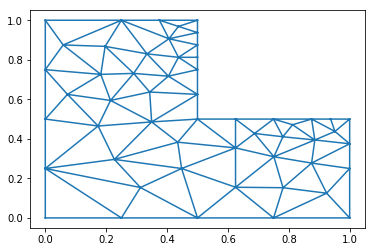

In [17]:
# mesh boundary ponts
points = [ (0,0),(1,0),(1,0.5),(0.5,0.5),(0.5, 1), (0,1) ]

def round_trip_connect(start, end):
  result = []
  for i in range(start, end):
    result.append((i, i+1))
  result.append((end, start))
  return result

def needs_refinement(vertices, area ):
    vert_origin, vert_destination, vert_apex = vertices
    
    # find the barycenter or center of mass of the triangle
    bary_x = (vert_origin.x + vert_destination.x + vert_apex.x) / 3
    bary_y = (vert_origin.y + vert_destination.y + vert_apex.y) / 3

    dist_center = math.sqrt( (bary_x-1)**2 + (bary_y-1)**2 )
    max_area = math.fabs( 0.05 * (dist_center-0.5) ) + 0.001
    return area > max_area

# create a mesh
info = triangle.MeshInfo()
info.set_points(points)
info.set_facets(round_trip_connect(0, len(points)-1))

mesh = triangle.build(info, refinement_func=needs_refinement)

# plot and save the mesh
import matplotlib.pyplot as pt
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_facets = np.array(mesh.facets)
pt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
pt.savefig('ini_mesh.png')
pt.show()
write_dat(mesh,mesh.facets,'ref_mesh.dat')




## Solve system 
We solve system on that mesh

In [18]:
mp, mt, mf = read_dat('ref_mesh.dat')

sol = fem_solve(mp, mt, mf, right_hand_side)

Plot the solution

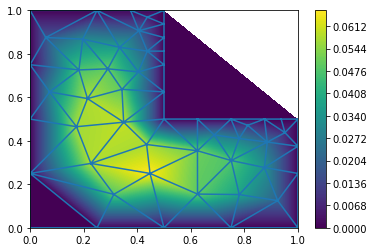

In [19]:

%matplotlib inline
import matplotlib.mlab as mlab
pt.triplot(mp[:, 0], mp[:, 1], mt)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()

**Process of refinement. ** N --- number of steps. 

In [20]:
# Refine edges with top 20% of error estimator
part = 0.2
N = 10
mp, mt, mf = read_dat('ref_mesh.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)

# the refinement algorithm is being run N times and the number of new points is printed and the refined meshes saved
for step in range(N):
    
    # refine the given mesh acording to the rule of refinement
    points = refine_true_rule(mp, mt, right_hand_side, sol, part)
    
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(mf)
    mesh = triangle.build(info_s, min_angle = 30)
    
    # saving mesh in file
    file_name  = 'ref_mesh'+str(step)+'.dat'
    write_dat(mesh,mesh.facets, file_name)
    mp, mt, mf = read_dat(file_name)
    sol = fem_solve(mp, mt, mf, right_hand_side)



10
22
27
35
45
59
74
94
122
154


Some additional code for numerical experiments with two algorithms. 

In [21]:
x = []
y = []

# refined solution considered as the reference solution
mp, mt, mf = read_dat('ref_mesh_good14.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)
# calculate the norm of the reference solution over the domain
ref_s = integrate_over_mesh(mp, mt, sol)

# solution for coarse unrefined mesh
mp, mt, mf = read_dat('ref_mesh.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)
# calculate the norm of the solution over the domain
integral_over = integrate_over_mesh(mp, mt, sol)

# number of points
x.append(len(mp))
# error for the coarse solution
y.append(abs(integral_over - ref_s))

N = 10
# calculate errors for adaptively refined solutions
for i in range(N):
    mp, mt, mf = read_dat('ref_mesh'+str(i)+'.dat')
    sol = fem_solve(mp, mt, mf, right_hand_side)
    integral_over = integrate_over_mesh(mp, mt, sol)
    x.append(len(mp))
    y.append(abs(integral_over - ref_s))

Below we calculate the indicator using the following formula: (which is expected to give better accuracy and more proper mesh)
$
((\nabla U_{T_1}- \nabla U_{T_2}), \vec n)^2*||e||^2, \ \ where \ e \ is \ the \ edge 
$

In [22]:
def compute_indicator_true1(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / la.norm(n)
            indicator[i] =  (np.dot((compute_grad(mt[int(neigh[i][0])], mp, sol) 
                        - compute_grad(mt[int(neigh[i][1])], mp, sol)), n)**2*la.norm(e)**2
                        + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2)))
            
    return indicator



In [23]:
def refine_true_rule1(mp, mt, right_hand_side, sol, part):
    
    # find all edges
    edges = get_edges(mt,mp)
    
    # find wich triangles are neighbours
    neigh = find_triangle_neighbours(edges, mt)
    
    # compute indicator for each edge
    ind = compute_indicator_true1(neigh, edges, mp, mt, sol, right_hand_side) 
    sort_ind = np.sort(ind)
    
    # find the top part of indicators
    number_of_new_points = int(math.floor(len(mp)*part)) 
    print (number_of_new_points)
    points = list(mp)
    for i in sort_ind[-number_of_new_points:]: #refine mesh
        for j in range(len(ind)):
            if i == ind[j]:
                new_p = (mp[edges[j][0]]+mp[edges[j][1]])/2.0
                if not if_contains(new_p, points):
                    points.append(np.array(new_p))
    return points



In [24]:
part = 0.2
N = 5
mp, mt, mf = read_dat('ref_mesh.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)

# the refinement algorithm is being run N times and the number of new points is printed and the refined meshes saved
# here the actual gradients are used and is exptected to work better than the previous approach
for step in range(N):
    
    points = refine_true_rule1(mp, mt, right_hand_side, sol, part)
    
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(mf)
    mesh = triangle.build(info_s, min_angle = 30)
    
    # saving mesh in file
    file_name  = 'ref_mesh_true'+str(step)+'.dat'
    write_dat(mesh,mesh.facets, file_name)
    mp, mt, mf = read_dat(file_name)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    print (step)



10
0
25
1
39
2
63
3
101
4


In [25]:
x1 = []
y1 = []
N = 5
mp, mt, mf = read_dat('ref_mesh.dat')
sol = fem_solve(mp, mt, mf, right_hand_side)

# the error is computed for the case of the true indicator
integral_over = integrate_over_mesh(mp, mt, sol)
x1.append(len(mp))
y1.append(abs(integral_over - ref_s))    

for i in range(N):
    mp, mt, mf = read_dat('ref_mesh_true'+str(i)+'.dat')
    sol = fem_solve(mp, mt, mf, right_hand_side)
    integral_over = integrate_over_mesh(mp, mt, sol)
    x1.append(len(mp))
    y1.append(abs(integral_over - ref_s))   

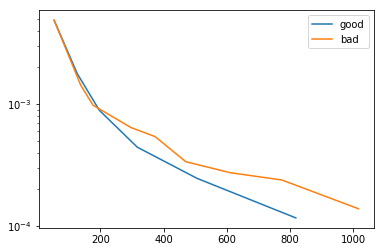

In [26]:
pt.semilogy(x1,y1, label ='good')
pt.semilogy(x,y, label = 'bad')
pt.legend()
pt.show()

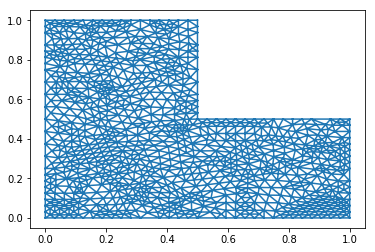

In [27]:
# plot mesh from approximation of indicator
mp, mt, mf = read_dat('ref_mesh9.dat')
pt.triplot(mp[:, 0], mp[:, 1], mt)


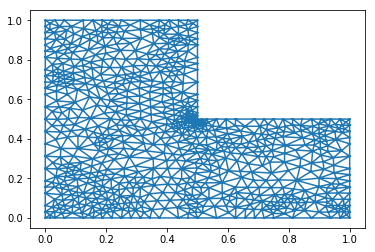

In [28]:
# plot mesh from true indicator
mp, mt, mf = read_dat('ref_mesh_true4.dat')
pt.triplot(mp[:, 0], mp[:, 1], mt)


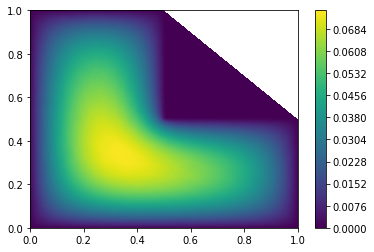

In [29]:
# calculate and plot the solution on the truly adaptively refined mesh
sol = fem_solve(mp, mt, mf, right_hand_side)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()

Min angle check (sanity check)

In [33]:
for i in mt:
    cos1 = math.acos(np.dot(mp[i[1]]-mp[i[0]],mp[i[2]]-mp[i[0]])/(la.norm(mp[i[1]]-mp[i[0]])*la.norm(mp[i[2]]-mp[i[0]])))
    cos2 = math.acos(np.dot(mp[i[2]]-mp[i[0]],mp[i[2]]-mp[i[1]])/(la.norm(mp[i[2]]-mp[i[0]])*la.norm(mp[i[2]]-mp[i[1]])))
    cos3 = math.acos(np.dot(mp[i[1]]-mp[i[0]],mp[i[1]]-mp[i[2]])/(la.norm(mp[i[1]]-mp[i[0]])*la.norm(mp[i[1]]-mp[i[2]])))
    if cos1 < np.pi/6 or cos2< np.pi/6 or cos3<np.pi/6:
        print (i)
